In [17]:
from models import *
import torch
import numpy as np
import random

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

## Chose model
model_class = PLSegmentationModel
model_path = 'saved_models/default_model_v2.model'

In [18]:
## Load model
model = model_class.load(model_path)

print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')


Model loaded from: 'saved_models/default_model_v2.model'
Trainable parameters: 4091


In [1]:
## Synthetic dataset
from models.psf import GuassionPSF
from simulation.grain_PL_simulation import TrainingDataSimulationOptions
from torch_utils.dataset import GeneratedPLOutlineDataset
from torch.utils.data import Dataset

from torchvision import transforms

from torch_utils.transform import BackgroundRemovalNormalize, SkipFrames


## 1 Pixel is 200 nm
def get_training_data(length: int = 20) -> Dataset:
    psf = GuassionPSF(2.5)

    factor = 2
    options = TrainingDataSimulationOptions(
        grid_size=256 // factor,
        min_grains=2200 // (2 * factor * factor),
        max_grains=3200 // (2 * factor * factor),
        min_noise=0.05 ,
        max_noise=0.12,
        sample_rate=10,
        seconds=11, ## Decides how many frames each test samples has: total frames = sample_rate * seconds
        min_blinker_transition=0.04,
        max_blinker_transition=0.1,
        min_base_counts=6000,
        max_base_counts=12000,
        min_hole_chance=0.01,
        max_hole_chance=0.1,
        min_boundary_dimish=0,    
        max_boundary_dimish=1.0,
        min_blinker_strength=0.005,
        max_blinker_strength=0.08,
        min_blinkers_average=50,
        max_blinkers_average=90,
        psf=psf,
    )

    generated_dataset = GeneratedPLOutlineDataset(length=20, 
                                              sim_options=options, 
                                              transforms=transforms.Compose([
                                                BackgroundRemovalNormalize(),
                                                SkipFrames(skip=3),
                                              ]),
                                              empty_chance=1)

    return generated_dataset

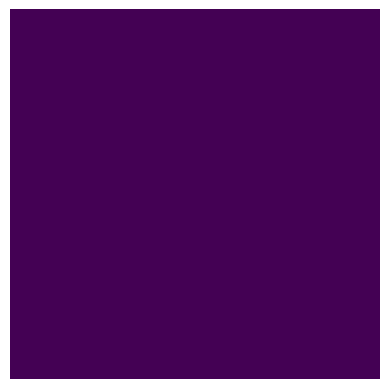

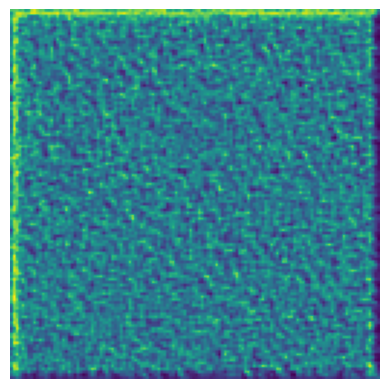

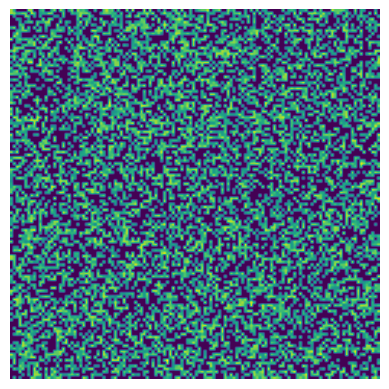

In [30]:
import torch

from torch_utils.transform import NormalizeIntensityTrace 

def inference(model: torch.nn.Module, input: torch.Tensor, apply_transforms: bool = False) -> torch.Tensor:
    if apply_transforms:
        f = transforms.Compose(
            [NormalizeIntensityTrace(),
            SkipFrames(skip=3),]
        )
        input = f(input)
    
    with torch.no_grad():
        ## Video data has shape (frames, width, height)
        ## Expected input: (batches, frames, channels, width, height)
        input = input.unsqueeze(0).unsqueeze(2)

        output = model.forward(input, inference=True)

        return output.squeeze(0).squeeze(0)


import matplotlib.pyplot as plt
# set_seed(43)

dataset = get_training_data(20)
# for _ in range(1000):
#     for i in range(20):
video, label = dataset.__getitem__(0)

output = inference(model, video).squeeze(0).squeeze(0)

plt.imshow(label)
plt.axis('off')

plt.subplots()

plt.imshow(output)
plt.axis('off')

plt.subplots()

plt.axis('off')
plt.imshow(video[0])

In [118]:
## Load some real data
from data_utils.tiff import tiff_to_array

## small grain
data = tiff_to_array('data/place1 485nm 50ms excod3.3 emod0 6000 frms air small enhancement _small grain_mv3.tif')

## big grain
# data = tiff_to_array('data/place1 485nm 50ms excod3.3 emod0 6000 frms air no enhancement mv4.tif')



In [125]:
## Profile FWHM
def get_fwhm_pos(data, peak_value):
    target = peak_value / 2
    
    last_value = peak_value
    for i in range(len(data)):
        value = data[i]

        if (value <= target):
            ## Lerp to find position of the peak
            weight = (target - last_value) / (value - last_value)
            fwhm_pos = i + weight

            return fwhm_pos
        
        last_value = value

    raise ValueError("No fwhm found")



def find_fwhm(peakpos, data, window=10):
    peak_value = data[peakpos]

    left_data = torch.flip(data[max(peakpos-window, 0):peakpos], [0])
    right_data = data[peakpos +1:max(peakpos+window, len(data))]

    left_pos = peakpos - get_fwhm_pos(left_data, peak_value)
    right_pos = peakpos + get_fwhm_pos(right_data, peak_value)
    
    return (left_pos, right_pos)


Inference took 0.5006463527679443 seconds
FWHM: 2.8757543563842773 pixels
FWHM: 4.030534744262695 pixels
FWHM: 8.604915618896484 pixels
FWHM: 19.659595489501953 pixels
FWHM: 4.7039337158203125 pixels
FWHM: 2.7214202880859375 pixels
FWHM: 1.866119384765625 pixels
FWHM: 2.6822357177734375 pixels
FWHM: 2.1870651245117188 pixels
FWHM: 3.0033950805664062 pixels
FWHM: 8.692230224609375 pixels
FWHM: 3.617919921875 pixels
FWHM: 2.456451416015625 pixels
Av width: 5.161659240722656


Text(0, 0.5, 'Model output')

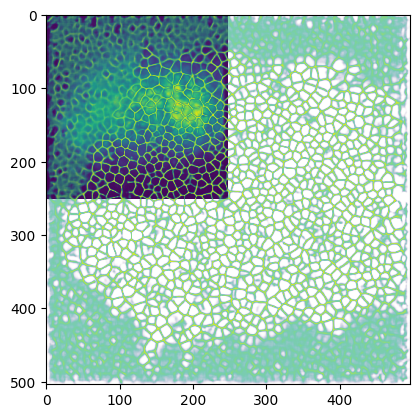

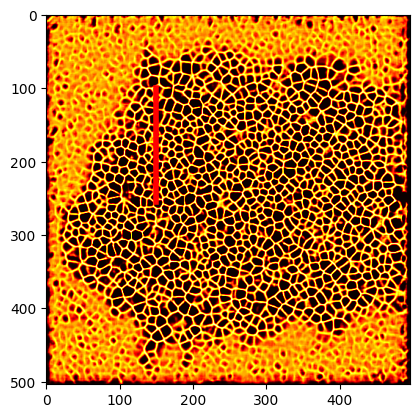

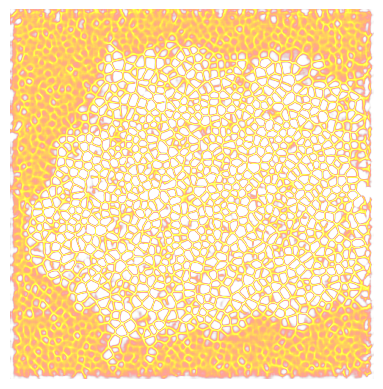

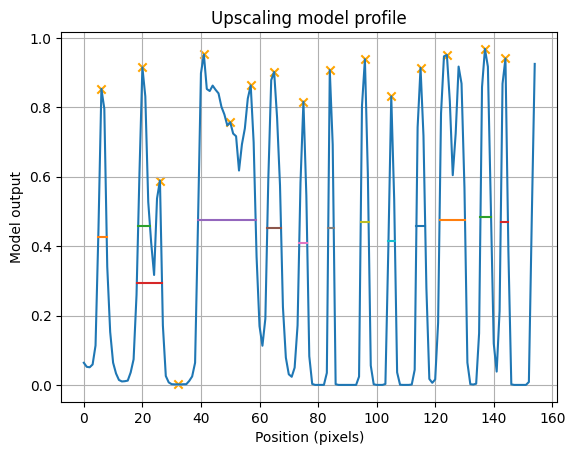

In [120]:
import numpy as np
import time

num_frames = 150


sample_video = data[:num_frames, :, :]
first_frame = sample_video[0]

start = time.time()
model_output = inference(model, sample_video, apply_transforms=True)
end = time.time()

print(f'Inference took {end - start} seconds')

## Profile line
scale = 1
x = 150 // scale
y_range = (100 // scale, 255 // scale)


## PL overlay plot
plt.subplots()

plt.imshow(first_frame)
plt.imshow(model_output, alpha=model_output)

## Map with black background
plt.subplots()

plt.imshow(model_output, cmap='hot')
# plt.axis('off')

plt.plot([x, x], [y_range[0], y_range[1]], color="red", linewidth=4)


## Transparant map
plt.subplots()

plt.imshow(model_output, alpha=model_output, cmap='hot')
plt.axis('off')
plt.savefig('test_transparant_map.png', transparent=True, dpi=500)

## Line profile
plt.subplots()

profile = model_output[x, y_range[0]:y_range[1]]
plt.plot(profile)

# peaks
from scipy.signal import find_peaks
peaks, _ = find_peaks(profile, distance=5)

plt.scatter(peaks, profile[peaks], marker='x', color='orange')

# fwhm
fwhm_widths = []
for peak in peaks:
    try:
        left, right = find_fwhm(peak, profile)
    except:
        continue

    plt.plot((left, right), (profile[peak] / 2, profile[peak] / 2))
    print(f'FWHM: {right - left} pixels')

    fwhm_widths.append(right - left)

print(f'Av width: {np.mean(fwhm_widths)}')

#
plt.grid()

plt.title('Upscaling model profile')
plt.xlabel('Position (pixels)')
plt.ylabel('Model output')





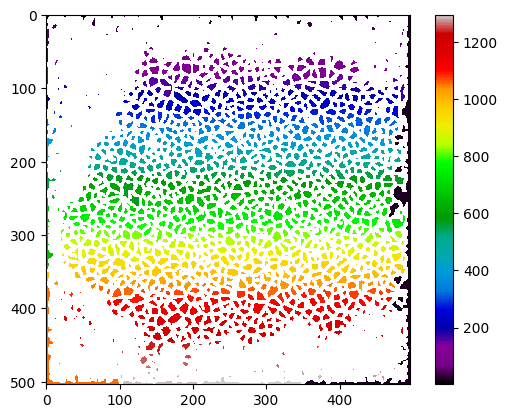

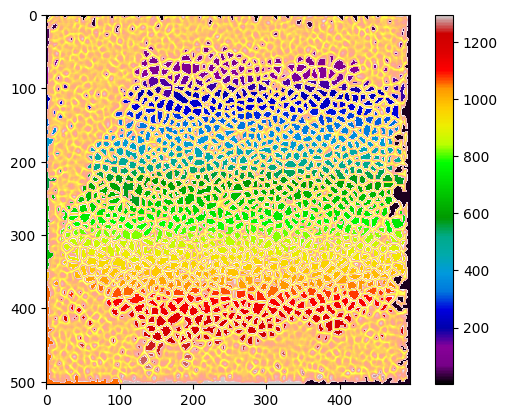

np.int32(1297)

(504, 496)

In [127]:
import numpy as np
from skimage import measure, morphology
import matplotlib.pyplot as plt
import torch

def border_to_clusters(border_image, threshold=0.5):
    # Convert PyTorch tensor to NumPy if needed
    if isinstance(border_image, torch.Tensor):
        border_image = border_image.detach().cpu().numpy()
    
    # Invert the image since borders are 1 and inside is 0
    inverted = 1 - border_image
    
    # Apply binary threshold to separate regions
    binary = inverted > threshold
    
    # Make sure it's a binary NumPy array with bool dtype
    binary = np.array(binary, dtype=bool)
    
    # Optional: Clean up small holes and artifacts
    cleaned = morphology.remove_small_holes(binary)
    cleaned = morphology.remove_small_objects(cleaned, min_size=5)
    

    # Label connected components (clusters)
    labeled_clusters = measure.label(cleaned)
    
    return labeled_clusters

# Example usage
labeled_clusters = border_to_clusters(model_output, threshold=0.7)

testing = labeled_clusters.copy().astype(np.float32)
testing[labeled_clusters == 0] = np.nan

plt.imshow(testing, cmap='nipy_spectral')
plt.colorbar()
plt.show()

plt.subplots()

plt.imshow(model_output, alpha=model_output, cmap='hot')
plt.imshow(testing, cmap='nipy_spectral')
plt.colorbar()
plt.show()


display(np.max(labeled_clusters))
labeled_clusters.shape

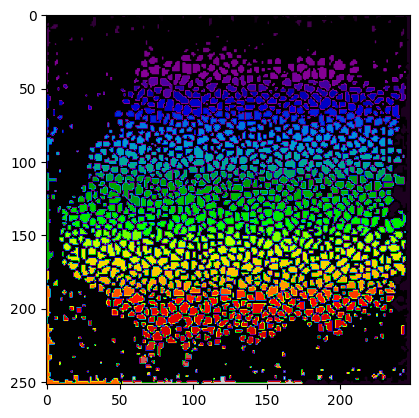

In [128]:
import numpy as np
from skimage.measure import block_reduce
from scipy import stats

def downscale_cluster_map(cluster_map, factor=2):
    """
    Downscale a cluster map by taking the most frequent value in each block.
    
    Parameters:
    -----------
    cluster_map : numpy.ndarray
        The input cluster map where each value is a cluster ID
    factor : int
        The downscaling factor (default: 2)
        
    Returns:
    --------
    numpy.ndarray
        The downscaled cluster map
    """
    h, w = cluster_map.shape
    new_h, new_w = h // factor, w // factor
    downscaled = np.zeros((new_h, new_w), dtype=cluster_map.dtype)
    
    for i in range(new_h):
        for j in range(new_w):
            # Extract the block
            block = cluster_map[i*factor:(i+1)*factor, j*factor:(j+1)*factor]
            # Find the most common value
            values, counts = np.unique(block, return_counts=True)
            downscaled[i, j] = values[np.argmax(counts)]
    
    return downscaled

num_pixels = data.shape[1] * data.shape[2]
frames = data.shape[0]
image_dim = [data.shape[1], data.shape[2]]

data_transposed = data.permute(1, 2, 0)

## The final cluster map has twice the dimensions of the input data so we have to reduce the dimenions again
downsampled_map = downscale_cluster_map(labeled_clusters)
flat_clusters = torch.reshape(torch.from_numpy(downsampled_map), [num_pixels])

testing = downsampled_map.copy().astype(np.float32)
# testing[testing == 0] = np.nan

plt.imshow(testing, cmap='nipy_spectral')

In [2]:
from data_utils.silhouette import get_silhouette_scores

data_to_use = data_transposed[:, :, :400]
silhouette_result  =get_silhouette_scores(data_to_use, downsampled_map, 6, 10)
## Calculate the distance between each pixel
# dist = pairwise_distances(reduced_data, reduced_data, metric='correlation', n_jobs=8)
# dist.shape

NameError: name 'data_transposed' is not defined

In [1]:
not_clustered = downsampled_map == 0
clustered = downsampled_map > 0

# silhouette_result[not_clustered] = np.nan

cmap = plt.get_cmap('viridis').copy()  # Or use your preferred colormap
cmap.set_bad('black')  # Set NaN values to black

plt.imshow(silhouette_result, cmap=cmap)
plt.colorbar()

plt.subplots()
plt.imshow(labeled_clusters)

plt.subplots()
plt.imshow(data_transposed[:,:,1])
silhouette_result[clustered].mean()

NameError: name 'downsampled_map' is not defined